<a href="https://colab.research.google.com/github/Avinash-Benki/Capstone-Project/blob/master/SpeechRecognitionLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!mkdir .kaggle

In [0]:
import json
token = {"username":"nivedithahn","key":"b0918f0e714fa25a112ffdbab3d43b49"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [23]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [25]:
!kaggle competitions download -c tensorflow-speech-recognition-challenge -p /content/gdrive/My\ Drive/SpeechRecognizer

  0% 0.00/501k [00:00<?, ?B/s]
100% 501k/501k [00:00<00:00, 34.3MB/s]
 99% 1.04G/1.04G [00:11<00:00, 130MB/s]
100% 1.04G/1.04G [00:11<00:00, 98.6MB/s]
100% 2.46G/2.46G [00:28<00:00, 80.9MB/s]
100% 2.46G/2.46G [00:28<00:00, 92.4MB/s]
  0% 0.00/50.0 [00:00<?, ?B/s]
100% 50.0/50.0 [00:00<00:00, 15.7kB/s]


In [0]:
import os
os.chdir('/content/gdrive/My Drive/SpeechRecognizer')

In [0]:
!mkdir train  #create a directory named train/
!mkdir test  #create a directory named test/

In [28]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [29]:
!p7zip -d train.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 38         0% 39 - train/audio/_background_noise_/dude_miaowing.wav                                                            0% 40 - train/audio/_background_noise_/exercise_bike.wav                                                            0% 42 - train/audio/_backgrou

In [1]:
!p7zip -d test.7z

/usr/bin/p7zip: cannot read test.7z


In [0]:
# importing all the dependencies
import pandas as pd # data frame
import numpy as np # matrix math
from glob import glob # file handling

import librosa # audio manipulation
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.utils import shuffle # shuffling of data
import os # interation with the OS
from random import sample # random selection
from tqdm import tqdm
from scipy import signal # audio processing
from scipy.io import wavfile # reading the wavfile

In [0]:
# fixed param
PATH = '/content/gdrive/My Drive/SpeechRecognizer/train/audio/'

In [0]:
def load_files(path):
    # write the complete file loading function here, this will return
    # a dataframe having files and labels
    # loading the files
    train_labels = os.listdir(PATH)
    train_labels.remove('_background_noise_')
    
    labels_to_keep = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', '_background_noise_']

    train_file_labels = dict()
    for label in train_labels:
        files = os.listdir(PATH + '/' + label)
        for f in files:
            train_file_labels[label + '/' + f] = label

    train = pd.DataFrame.from_dict(train_file_labels, orient='index')
    train = train.reset_index(drop=False)
    train = train.rename(columns={'index': 'file', 0: 'folder'})
    train = train[['folder', 'file']]
    train = train.sort_values('file')
    train = train.reset_index(drop=True)

    def remove_label_from_file(label, fname):
        return path + label + '/' + fname[len(label)+1:]

    train['file'] = train.apply(lambda x: remove_label_from_file(*x), axis=1)
    train['label'] = train['folder'].apply(lambda x: x if x in labels_to_keep else 'unknown')

    labels_to_keep.append('unknown')

    return train, labels_to_keep

In [0]:
train, labels_to_keep = load_files(PATH)

# making word2id dict
word2id = dict((c,i) for i,c in enumerate(sorted(labels_to_keep)))

# get some files which will be labeled as unknown
unk_files = train.loc[train['label'] == 'unknown']['file'].values
unk_files = sample(list(unk_files), 1000)

In [19]:
word2id

{'_background_noise_': 0,
 'down': 1,
 'go': 2,
 'left': 3,
 'no': 4,
 'off': 5,
 'on': 6,
 'right': 7,
 'stop': 8,
 'unknown': 9,
 'up': 10,
 'yes': 11}

In [36]:
unk_files[:10]

['/content/gdrive/My Drive/SpeechRecognizer/train/audio/five/8781f4c1_nohash_1.wav',
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/zero/89f3ab7d_nohash_0.wav',
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/eight/857366dd_nohash_0.wav',
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/seven/7fd25f7c_nohash_4.wav',
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/three/51055bda_nohash_4.wav',
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/six/b1df80c0_nohash_0.wav',
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/marvin/bf70feda_nohash_0.wav',
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/two/1338a799_nohash_3.wav',
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/four/1e9b215e_nohash_0.wav',
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/four/c1d39ce8_nohash_6.wav']

In [20]:
train.sample(12)

,folder,file,label
8555,down,/content/gdrive/My Drive/SpeechRecognizer/trai...,down
1110,bed,/content/gdrive/My Drive/SpeechRecognizer/trai...,unknown
9353,eight,/content/gdrive/My Drive/SpeechRecognizer/trai...,unknown
6072,dog,/content/gdrive/My Drive/SpeechRecognizer/trai...,unknown
12588,five,/content/gdrive/My Drive/SpeechRecognizer/trai...,unknown
232,bed,/content/gdrive/My Drive/SpeechRecognizer/trai...,unknown
1507,bed,/content/gdrive/My Drive/SpeechRecognizer/trai...,unknown
1417,bed,/content/gdrive/My Drive/SpeechRecognizer/trai...,unknown
1906,bird,/content/gdrive/My Drive/SpeechRecognizer/trai...,unknown
4049,cat,/content/gdrive/My Drive/SpeechRecognizer/trai...,unknown


In [8]:
files = glob(PATH + '_bac*/*.wav')
print(files)

['/content/gdrive/My Drive/SpeechRecognizer/train/audio/_background_noise_/doing_the_dishes.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/_background_noise_/pink_noise.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/_background_noise_/white_noise.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/_background_noise_/running_tap.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/_background_noise_/dude_miaowing.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/_background_noise_/exercise_bike.wav']


In [9]:
# silence background samples
all_sil = []
for s in files:
    sr, audio = wavfile.read(s)
    # converting the file into samples of 1 sec each
    len_ = int(len(audio)/sr)
    print(len_)
    for i in range(len_-1):
        sample_ = audio[i*sr:(i+1)*sr]
        all_sil.append(sample_)
print(len(all_sil))
print(all_sil[0].shape)
sil_data =  np.zeros((392, 16000, ))
for i,d in enumerate(all_sil):
    sil_data[i] = d
print(sil_data.shape)

/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


95
60
60
61
61
61
392
(16000,)
(392, 16000)


In [0]:
# Writing functions to extract the data, script from kdnuggets: 
# www.kdnuggets.com/2016/09/urban-sound-classification-neural-networks-tensorflow.html
def extract_feature(path):
	X, sample_rate = librosa.load(path)
	stft = np.abs(librosa.stft(X))
	mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
	chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
	mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
	contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
	tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
	return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(files, word2id, unk = False):
    # n: number of classes
    features = np.empty((0,193))
    one_hot = np.zeros(shape = (len(files), word2id[max(word2id)]))
    print(one_hot.shape)
    for i in tqdm(range(len(files))):
        f = files[i]
        mfccs, chroma, mel, contrast,tonnetz = extract_feature(f)
        ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
        features = np.vstack([features,ext_features])
        if unk == True:
            l = word2id['unknown']
            one_hot[i][l] = 1.
        else:
            l = word2id[f.split('/')[-2]]
            one_hot[i][l] = 1.
    return np.array(features), one_hot

In [11]:
files = train.loc[train['label'] != 'unknown']['file'].values
print(len(files))
print(files[:10])

2359
['/content/gdrive/My Drive/SpeechRecognizer/train/audio/down/00176480_nohash_0.wav'
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/down/004ae714_nohash_0.wav'
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/down/00b01445_nohash_0.wav'
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/down/00b01445_nohash_1.wav'
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/down/00f0204f_nohash_0.wav'
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/down/0132a06d_nohash_0.wav'
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/down/0132a06d_nohash_1.wav'
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/down/0132a06d_nohash_2.wav'
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/down/0132a06d_nohash_3.wav'
 '/content/gdrive/My Drive/SpeechRecognizer/train/audio/down/0132a06d_nohash_4.wav']


## Data Visualization

In [0]:
# playing around with the data for now
train_audio_path = '/content/gdrive/My Drive/SpeechRecognizer/train/audio'
filename = '/down/0132a06d_nohash_4.wav' # --> 'DOWN'
sample_rate, audio = wavfile.read(str(train_audio_path) + filename)

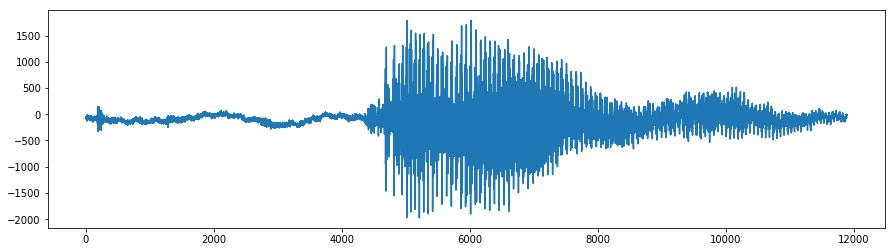

In [49]:
plt.figure(figsize = (15, 4))
plt.plot(audio)
ipd.Audio(audio, rate=sample_rate)

In [0]:
# goto: https://medium.com/@ageitgey/machine-learning-is-fun-part-6-how-to-do-speech-recognition-with-deep-learning-28293c162f7a
# We convert it into chunks of 20ms each i.e. units of 320 
audio_chunks = []
n_chunks = int(audio.shape[0]/320)
for i in range(n_chunks):
    chunk = audio[i*320: (i+1)*320]
    audio_chunks.append(chunk)
audio_chunk = np.array(audio_chunks)

In [0]:
# we now convert it to spertogram
# goto: https://www.kaggle.com/davids1992/data-visualization-and-investigation
def log_specgram(audio, sample_rate, window_size=10,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    _, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return np.log(spec.T.astype(np.float32) + eps)

(81, 100)


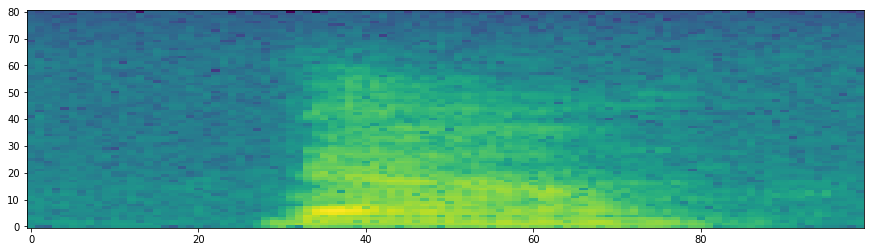

In [23]:
spectrogram = log_specgram(audio, sample_rate, 10, 0)
spec = spectrogram.T
print(spec.shape)
plt.figure(figsize = (15,4))
plt.imshow(spec, aspect='auto', origin='lower')

## DATA Preparation

In [24]:
# make labels and convert them into one hot encodings
labels = sorted(labels_to_keep)
word2id = dict((c,i) for i,c in enumerate(labels))
label = train['label'].values
label = [word2id[l] for l in label]
print(labels)
def make_one_hot(seq, n):
    # n --> vocab size
    seq_new = np.zeros(shape = (len(seq), n))
    for i,s in enumerate(seq):
        seq_new[i][s] = 1.
    return seq_new
one_hot_l = make_one_hot(label, 12)

['_background_noise_', 'down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'unknown', 'up', 'yes']


In [25]:
print(one_hot_l[10:15])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [26]:
one_hot_l[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [0]:
# getting all the paths to the files
root_path_train = '/content/gdrive/My Drive/SpeechRecognizer/train/audio/'
paths = []
folders = train['folder']
files = train['file']
for i in range(len(files)):
    path = str(files[i])
    paths.append(path)

In [28]:
print(paths[0:10])

['/content/gdrive/My Drive/SpeechRecognizer/train/audio/bed/00176480_nohash_0.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/bed/004ae714_nohash_0.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/bed/004ae714_nohash_1.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/bed/00f0204f_nohash_0.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/bed/00f0204f_nohash_1.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/bed/012c8314_nohash_0.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/bed/012c8314_nohash_1.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/bed/0132a06d_nohash_0.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/bed/0135f3f2_nohash_0.wav', '/content/gdrive/My Drive/SpeechRecognizer/train/audio/bed/0137b3f4_nohash_0.wav']


In [0]:
def audio_to_data(path):
    # we take a single path and convert it into data
    sample_rate, audio = wavfile.read(path)
    spectrogram = log_specgram(audio, sample_rate, 10, 0)
    return spectrogram.T

def paths_to_data(paths,labels):
    data = np.zeros(shape = (len(paths), 81, 100))
    indexes = []
    for i in tqdm(range(len(paths))):
        audio = audio_to_data(paths[i])
        if audio.shape != (81,100):
            indexes.append(i)
        else:
            data[i] = audio
    final_labels = [l for i,l in enumerate(labels) if i not in indexes]
    print('Number of instances with inconsistent shape:', len(indexes))
    return data[:len(data)-len(indexes)], final_labels, indexes

In [30]:
train_data,labels,indexs= paths_to_data(paths,one_hot_l)

100%|██████████| 14714/14714 [1:22:06<00:00,  2.96it/s]


Number of instances with inconsistent shape: 1570


In [0]:
command_labels = np.zeros(shape = [d.shape[0], len(labels[0])])
for i,array in enumerate(labels):
    for j, element in enumerate(array):
        command_labels[i][j] = element
print(command_labels.shape)

In [0]:
print(train_data.shape)
print(command_labels.shape)

In [0]:
train_data,command_labels = shuffle(train_data,command_labels)

In [0]:
print(train_data[0].shape)
print(command_labels[0].shape)

## Machine Learning Model

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [0]:
model = Sequential()
model.add(LSTM(256, input_shape = (81, 100)))
# model.add(Dense(1028))
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(12, activation = 'softmax'))
model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [0]:
model.summary()

In [0]:
model.fit(train_data, command_labels, batch_size = 1024, epochs = 10)